In [23]:
import os
import numpy as np

In [24]:
FILES_DIR = 'saliency_experiment_outputs'


# list all files in the directory
folders = os.listdir(FILES_DIR)
for folder in folders:
    # open numpy_saliency_maps folder
    folder_path = os.path.join(FILES_DIR, folder, 'numpy_saliency_maps')
    batch_maps_path = os.path.join(folder_path, 'batch_maps.npy')
    
    # Skip if batch_maps.npy already exists
    if os.path.exists(batch_maps_path):
        print(f'Batch maps already exist for {folder}, skipping...')
        continue
        
    batch_maps = np.array([])
    for file in os.listdir(folder_path):
        # load the numpy file and append it to the batch_maps array
        file_path = os.path.join(folder_path, file)
        saliency_map = np.load(file_path)
        # Check the shape of the loaded saliency map
        if len(saliency_map.shape) == 2:
            # If it's a 2D array (H, W), add a new axis to make it 3D (1, H, W)
            saliency_map = saliency_map[np.newaxis, :, :]
        else:
            print(f"Warning: Unexpected shape for {file}: {saliency_map.shape}. stop processing all files in this folder.")
            break
            
        # if batch_maps is empty, set it to saliency_map
        if batch_maps.size == 0:
            batch_maps = saliency_map
        else:
            # Make sure dimensions match before concatenating
            if batch_maps.shape[1:] != saliency_map.shape[1:]:
                print(f"Warning: Shape mismatch - batch_maps: {batch_maps.shape}, saliency_map: {saliency_map.shape}")
                continue
            # concatenate the saliency map to the batch_maps array
            batch_maps = np.concatenate((batch_maps, saliency_map), axis=0)
    
    # save the batch_maps array to a numpy file
    np.save(batch_maps_path, batch_maps)
    # print the shape of the batch_maps array
    print(f'Batch maps shape for {folder}: {batch_maps.shape}')

Batch maps already exist for Pruned_Model, skipping...
Batch maps already exist for Baseline_Model, skipping...


In [25]:
from scipy.stats import pearsonr, spearmanr, wasserstein_distance
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from itertools import combinations
  
def compare_heatmaps(heatmap_arrays, metrics=['mse', 'correlation', 'cosine', 'ssim', 'emd']):
    """
    Compare similarity between multiple heatmap arrays.
    
    Args:
        heatmap_arrays: List of numpy arrays, each with shape (n_images, height, width)
        metrics: List of metrics to compute ('mse', 'correlation', 'cosine', 'ssim', 'emd')
        
    Returns:
        Dictionary containing results for each metric and each pair of arrays
    """
    n_arrays = len(heatmap_arrays)
    n_images = heatmap_arrays[0].shape[0]
    
    # Validate input shapes
    for i, arr in enumerate(heatmap_arrays):
        if arr.shape != heatmap_arrays[0].shape:
            raise ValueError(f"Array {i} has shape {arr.shape}, expected {heatmap_arrays[0].shape}")
    
    # Initialize results dictionary
    results = {metric: {} for metric in metrics}
    
    # Generate all pairs of arrays to compare
    array_pairs = list(combinations(range(n_arrays), 2))
    
    # For each pair of arrays
    for (i, j) in array_pairs:
        pair_key = f"{i}_vs_{j}"
        
        # Initialize per-image results
        if 'mse' in metrics:
            results['mse'][pair_key] = np.zeros(n_images)
        if 'correlation' in metrics:
            results['correlation'][pair_key] = np.zeros(n_images)
        if 'cosine' in metrics:
            results['cosine'][pair_key] = np.zeros(n_images)
        if 'ssim' in metrics:
            results['ssim'][pair_key] = np.zeros(n_images)
        if 'emd' in metrics:
            results['emd'][pair_key] = np.zeros(n_images)
        
        # Compute metrics for each image pair
        for img_idx in range(n_images):
            heatmap1 = heatmap_arrays[i][img_idx]
            heatmap2 = heatmap_arrays[j][img_idx]
            
            # Flatten arrays for some metrics
            flat1 = heatmap1.flatten()
            flat2 = heatmap2.flatten()
            
            # Calculate metrics
            if 'mse' in metrics:
                results['mse'][pair_key][img_idx] = mean_squared_error(flat1, flat2)
            
            if 'correlation' in metrics:
                # Pearson correlation
                results['correlation'][pair_key][img_idx] = pearsonr(flat1, flat2)[0]
            
            if 'cosine' in metrics:
                # Reshape for cosine similarity
                results['cosine'][pair_key][img_idx] = cosine_similarity(
                    flat1.reshape(1, -1), flat2.reshape(1, -1)
                )[0][0]
            
            if 'ssim' in metrics:
                # Structural similarity
                # Ensure data range is appropriate, especially if heatmaps are normalized
                min_val = min(heatmap1.min(), heatmap2.min())
                max_val = max(heatmap1.max(), heatmap2.max())
                data_range = max_val - min_val if max_val > min_val else 1.0 # Avoid division by zero
                results['ssim'][pair_key][img_idx] = ssim(
                    heatmap1, heatmap2, data_range=data_range
                )
            
            if 'emd' in metrics:
                # Earth Mover's Distance (Wasserstein distance)
                results['emd'][pair_key][img_idx] = wasserstein_distance(flat1, flat2)
    
    # Compute summary statistics
    summary = {metric: {} for metric in metrics}
    for metric in metrics:
        for pair_key in results[metric]:
            summary[metric][pair_key] = {
                'mean': np.mean(results[metric][pair_key]),
                'std': np.std(results[metric][pair_key]),
                'min': np.min(results[metric][pair_key]),
                'max': np.max(results[metric][pair_key]),
                'median': np.median(results[metric][pair_key])
            }
    
    return {'per_image': results, 'summary': summary}

def visualize_similarity_matrix(results, model_names, metric='cosine', stat='mean', 
                               figsize=(12, 8), cmap='coolwarm', annotate=True):
    """
    Visualize similarity matrix between models based on specified metric and statistic.
    
    Args:
        results: Dictionary output from compare_heatmaps function
        model_names: List of model names for labeling the matrix
        metric: The similarity metric to visualize ('cosine', 'correlation', 'ssim', 'mse', 'emd')
        stat: The statistic to use ('mean', 'median', 'min', 'max', 'std')
        figsize: Size of the figure (width, height)
        cmap: Colormap for the heatmap
        annotate: Whether to annotate the cells with values
        
    Returns:
        matplotlib figure object
    """
    if metric not in results['summary']:
        raise ValueError(f"Metric '{metric}' not found in results. Available metrics: {list(results['summary'].keys())}")
    
    n_models = len(model_names)
    similarity_matrix = np.zeros((n_models, n_models))
    
    # Diagonal elements (self-similarity)
    for i in range(n_models):
        if metric == 'mse' or metric == 'emd':  # For MSE/EMD, self-similarity is 0
            similarity_matrix[i, i] = 0.0
        else:  # For other metrics, self-similarity is 1
            similarity_matrix[i, i] = 1.0
    
    # Fill matrix with values from results
    for pair, metrics_data in results['summary'][metric].items():
        i, j = map(int, pair.split('_vs_'))
        similarity_matrix[i, j] = metrics_data[stat]
        # Similarity is symmetric for these metrics
        similarity_matrix[j, i] = metrics_data[stat]
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # For MSE/EMD, lower values are better, so use a reverse colormap if default is used
    if metric == 'mse':
        if cmap == 'coolwarm':
            cmap = 'coolwarm_r'  # Reversed version
        label = "Mean Squared Error"
    elif metric == 'emd':
        if cmap == 'coolwarm':
            cmap = 'coolwarm_r' # Reversed version
        label = "Earth Mover's Distance (Wasserstein)"
    else:
        label = f"{metric.capitalize()} Similarity"
    
    ax = sns.heatmap(
        similarity_matrix,
        annot=annotate,
        fmt=".2f",
        cmap=cmap,
        xticklabels=model_names,
        yticklabels=model_names,
        cbar_kws={"label": label}
    )
    
    plt.title(f"{metric.upper() if metric == 'mse' or metric == 'emd' else metric.capitalize()} {stat.capitalize()} Between Heatmaps of Different Models")
    plt.tight_layout()
    
    return plt.gcf()

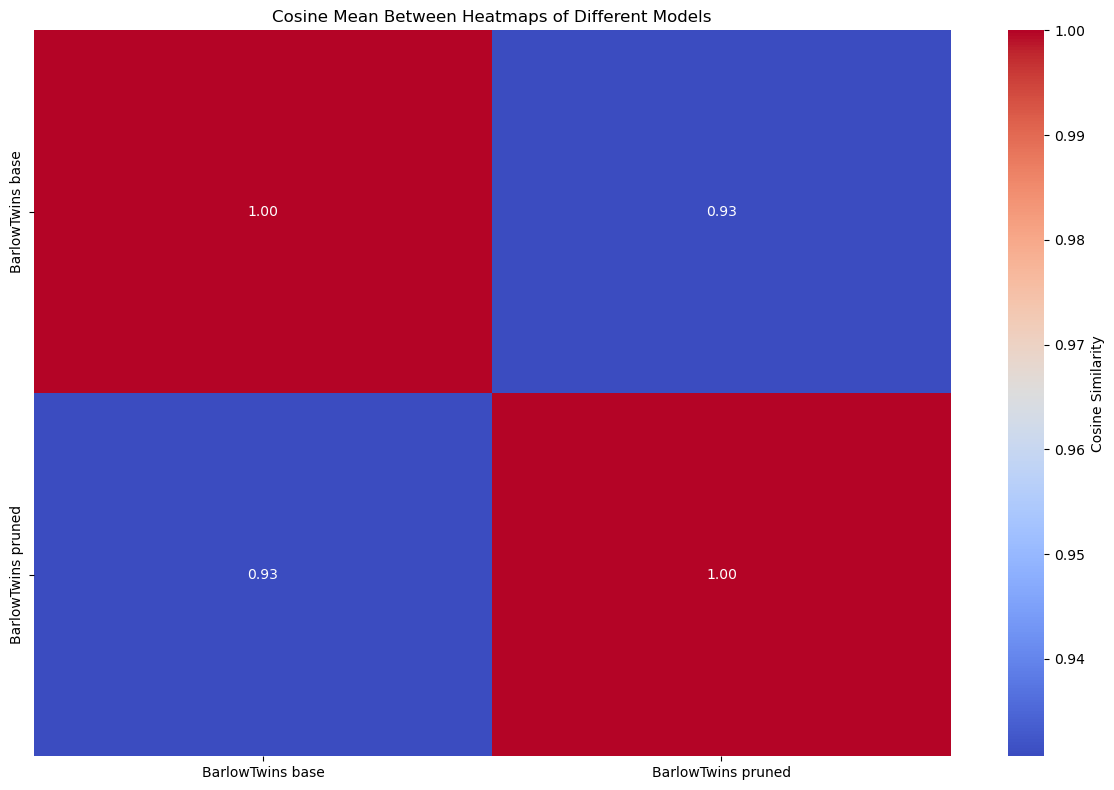

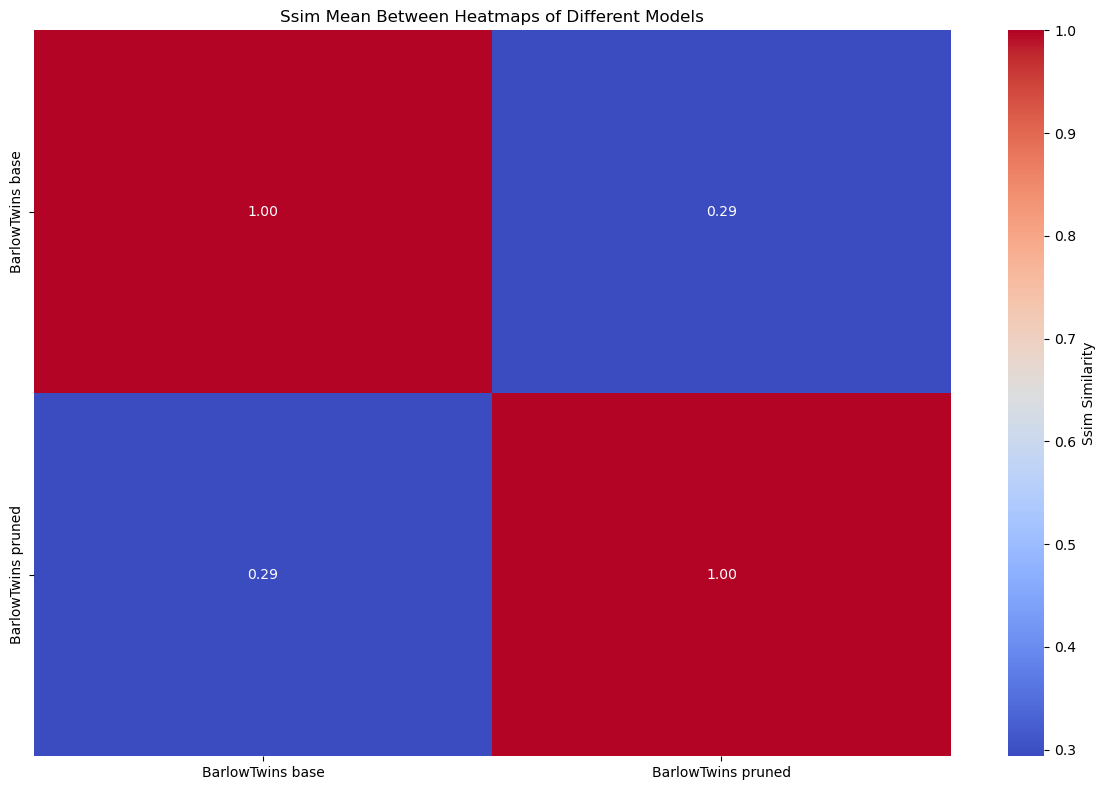

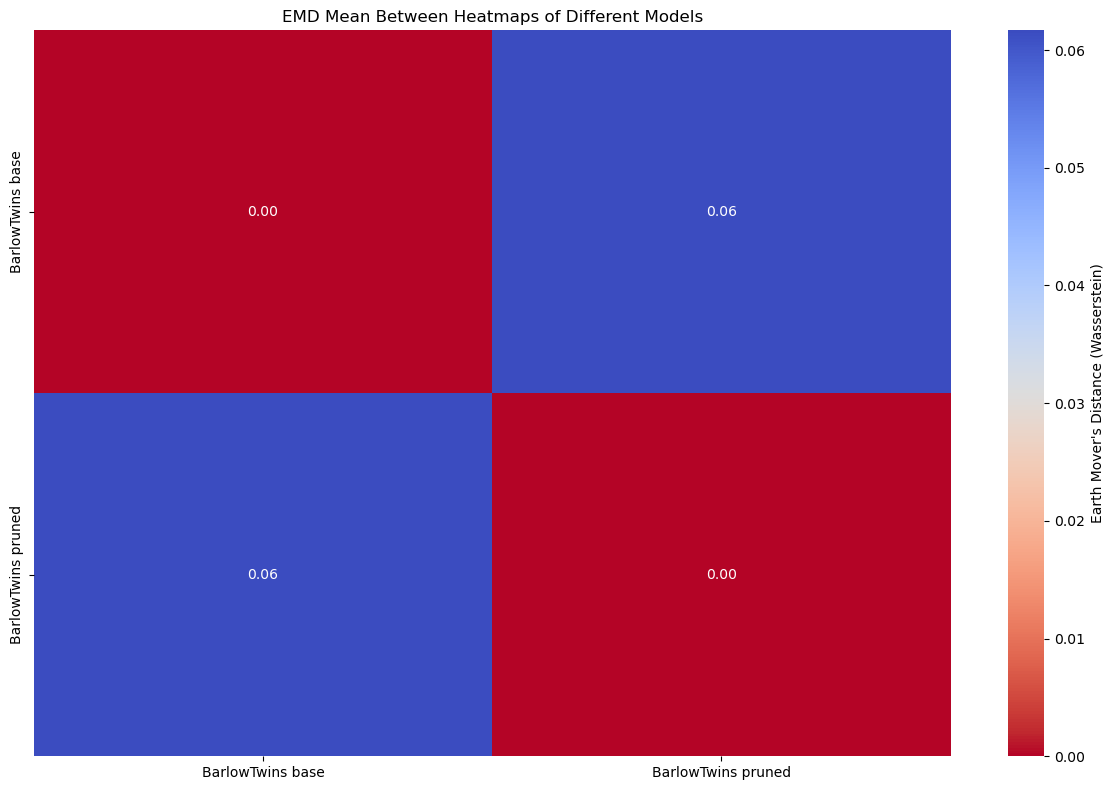

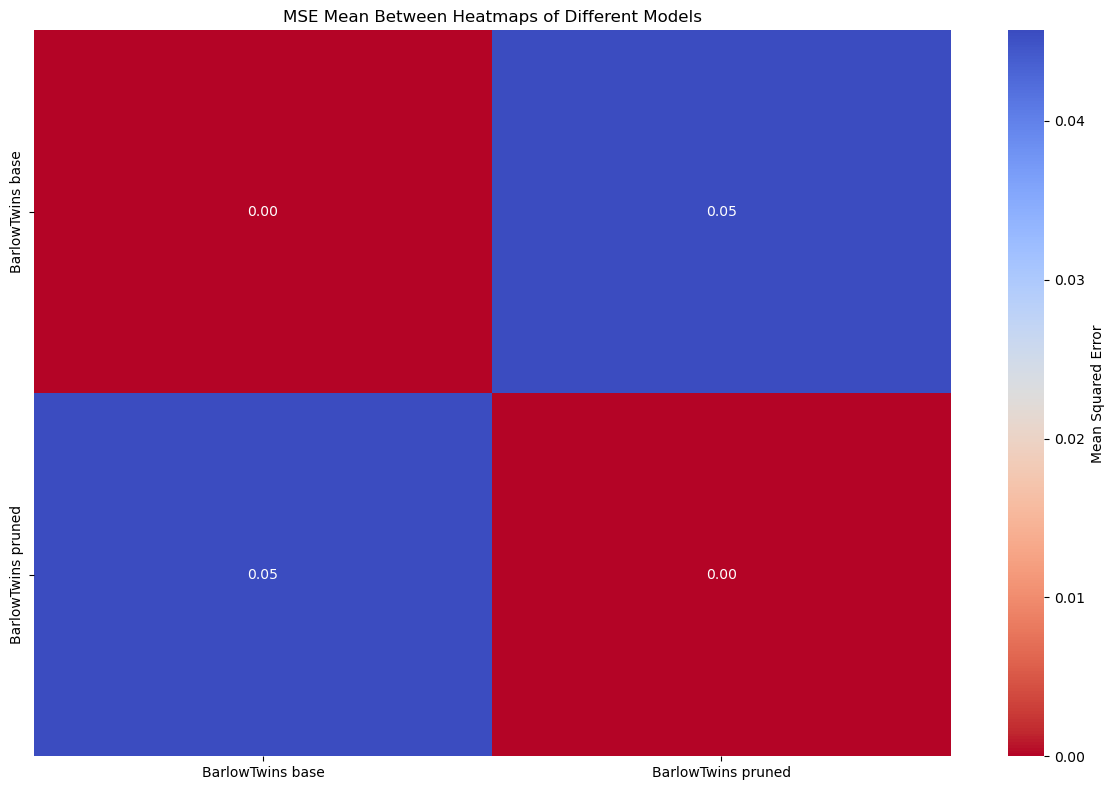

In [28]:
BASELINE_HEATMAPS_DIR = os.path.join(FILES_DIR, 'Baseline_Model', 'numpy_saliency_maps', 'batch_maps.npy')
PRUNED_HEATMAPS_DIR = os.path.join(FILES_DIR, 'Pruned_Model', 'numpy_saliency_maps', 'batch_maps.npy')

# Load the heatmaps
base_heatmaps = np.load(BASELINE_HEATMAPS_DIR)
pruned_heatmaps = np.load(PRUNED_HEATMAPS_DIR)

heatmaps = [
    base_heatmaps,
    pruned_heatmaps,
]

model_names = [
    "BarlowTwins base",
    "BarlowTwins pruned",
]

heatmaps_results = compare_heatmaps(heatmaps, metrics=['mse', 'correlation', 'cosine', 'ssim', 'emd'])

# Visualize the similarity matrix for each metric
visualize_similarity_matrix(heatmaps_results, model_names, metric='cosine', stat='mean')

visualize_similarity_matrix(heatmaps_results, model_names, metric='ssim', stat='mean')

visualize_similarity_matrix(heatmaps_results, model_names, metric='emd', stat='mean')

visualize_similarity_matrix(heatmaps_results, model_names, metric='mse', stat='mean')

# Show the plots
plt.show()